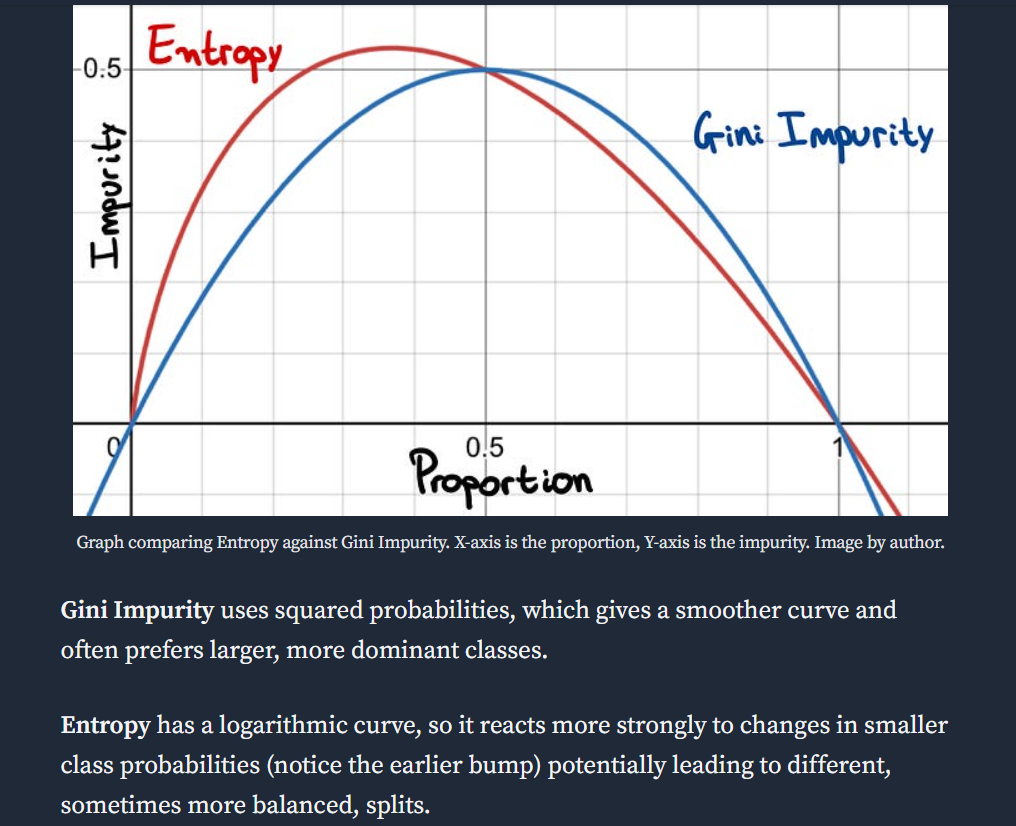

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
class TreeNode:
    def __init__(self, key=None, feature=None, threshold=None, left=None, right=None):
        self.feature = feature
        self.threshold = threshold
        self.val = key
        self.left = left
        self.right = right

In [ ]:
class DecisionTree:
    """
    Decision tree for binary classification implemented from scratch
    """
    def __init__(self, max_depth, min_samples_split, root):
        """
        max_depth - maximum depth of tree we can have
        min_samples_split - minimum number of samples we need to have before doing a split
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = root


    def fit(self, X, y):
        self.root = self.build_tree(X, y, depth=0)


    def build_tree(self, X, y, depth):
        """
        the core of Decision tree !!!
        this function recursively splits the examples based on gini impurity
        """
        # base case
        if X.shape[0] < self.min_samples_split or depth == self.max_depth or len(set(y)) == 1:
            # when less samples left, or depth reached, or homogeneous split achieved
            return TreeNode(key=self.most_common_label(y))

        # get the best feature and threshold of current set
        best_feature, best_threshold = self.best_split(X, y)

        # no valid split is found, create a leaf node
        if best_feature is None:
            return TreeNode(key=self.most_common_label(y))

        # split the data
        left_samples, right_samples = self.split_data(X, best_feature, best_threshold)

        # make subtrees
        left_subtree = self.build_tree(X[left_samples], y[left_samples], depth+1)
        right_subtree = self.build_tree(X[right_samples], y[right_samples], depth+1)

        return TreeNode(
            feature=best_feature, threshold=best_threshold,
            left=left_subtree, right=right_subtree
        )


    def best_split(self, X, y):
        """
        this method helps in finding feature and threshold for best split
        """
        best_feature, best_threshold = None, None
        best_score = float('inf')
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = [] # yes
                right_indices = [] # no
                left_indices, right_indices = self.split_data(X, feature, threshold)
                score = self.gini_score(left_indices, right_indices, y)
                if score < best_score:
                    best_score = score
                    best_feature, best_threshold = feature, threshold

        return best_feature, best_threshold


    def split_data(self, X, feature, threshold):
        """
        for a given feature and threshold, split the data in two halves
        """
        left_indices = [] # yes
        right_indices = [] # no
        for idx, sample in enumerate(X[:, feature]):
            if sample >= threshold:
                left_indices.append(idx)
            else:
                right_indices.append(idx)

        return left_indices, right_indices


    def gini_score(self, left_indices, right_indices, y):
        """
        get weighted gini score for a provided split
        """
        def gini(indices):
            if len(indices) == 0:
                # just in case we have split resulting in empty subtree
                return 0
            label_1 = sum(y[indices] == 1) / len(indices)
            label_0 = sum(y[indices] == 0) / len(indices)
            return 1 - label_1 ** 2 - label_0 ** 2

        return len(left_indices) * gini(left_indices) / len(y) + len(right_indices) * gini(right_indices) / len(y)


    def most_common_label(self, y):
        """
        get the most common label in current node (is called when base case is triggered)
        """
        freq = defaultdict(int)
        for val in y:
            freq[val] += 1
        label = max(freq, key=freq.get)

        return label


    def predict_one(self, example, node):
        """
        sample - shape: (num_features, )
        node - trained decision tree root node
        """
        # guided dfs
        while node.left or node.right:
            if example[node.feature] >= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.val


    def predict(self, X):
        """
        X - shape: (num_samples, num_features)
        """
        y_pred = [self.predict_one(example, self.root) for example in X]
        return np.array(y_pred)

In [ ]:
X, y = make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.0,
    random_state=23
)

<Axes: >

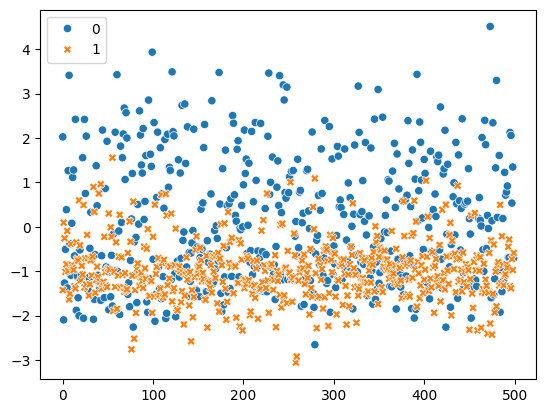

In [ ]:
sns.scatterplot(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=41
)

In [ ]:
model = DecisionTree(6, 10, TreeNode())

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        55
           1       0.93      0.91      0.92        45

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



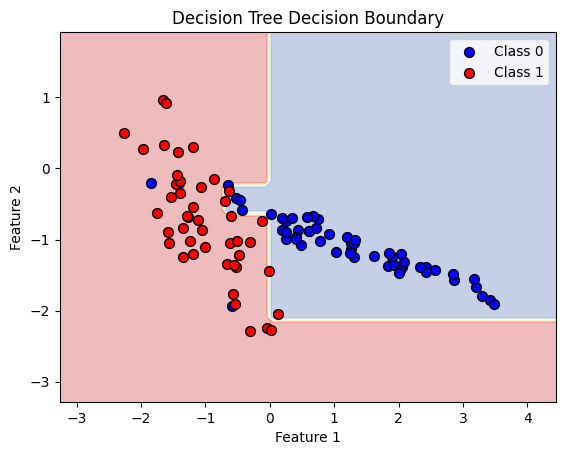

In [ ]:
# Thank you gawd GPT !!

def plot_decision_boundary(tree, X, y):
    # Define the mesh grid range based on X's min and max values
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Use the predict method on the entire grid of points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training points
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu_r')
    # plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='RdYlBu_r')
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0', edgecolor='k', s=50)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1', edgecolor='k', s=50)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.title("Decision Tree Decision Boundary")
    plt.show()

# Assuming `tree` is the instance of your DecisionTree class,
# and `X` and `y` are your feature and target arrays:
plot_decision_boundary(model, X_test, y_test)


In [ ]:
# Thank you gawd GPT !!

def print_tree(node, depth=0):
    # Check if the current node is a leaf node
    if node.left is None and node.right is None:
        print(f"{'|   ' * depth}Leaf: {node.val}")
        return

    # Print the decision rule for the current node
    print(f"{'|   ' * depth}Feature {node.feature} <= {node.threshold}")

    # Recursively print the left and right subtrees
    if node.left:
        print(f"{'|   ' * (depth + 1)}Left:")
        print_tree(node.left, depth + 1)
    if node.right:
        print(f"{'|   ' * (depth + 1)}Right:")
        print_tree(node.right, depth + 1)

print_tree(model.root)

Feature 0 <= 0.010490238199189927
|   Left:
|   Feature 1 <= -2.1789662322793735
|   |   Left:
|   |   Feature 1 <= -1.6832591444975753
|   |   |   Left:
|   |   |   Feature 0 <= 0.0784178405931597
|   |   |   |   Left:
|   |   |   |   Leaf: 0
|   |   |   |   Right:
|   |   |   |   Leaf: 0
|   |   |   Right:
|   |   |   Leaf: 0
|   |   Right:
|   |   Leaf: 1
|   Right:
|   Feature 1 <= -0.674809692175838
|   |   Left:
|   |   Feature 0 <= -0.7578834254776265
|   |   |   Left:
|   |   |   Feature 1 <= -0.20981594431514172
|   |   |   |   Left:
|   |   |   |   Leaf: 1
|   |   |   |   Right:
|   |   |   |   Feature 0 <= -0.266280332097222
|   |   |   |   |   Left:
|   |   |   |   |   Leaf: 0
|   |   |   |   |   Right:
|   |   |   |   |   Leaf: 0
|   |   |   Right:
|   |   |   Feature 0 <= -1.2063240276096026
|   |   |   |   Left:
|   |   |   |   Feature 0 <= -1.192065899547414
|   |   |   |   |   Left:
|   |   |   |   |   Feature 1 <= -0.3509590013083521
|   |   |   |   |   |   Left:
|   

## Miscellaneous

In [ ]:
# Level order traversal of a binary tree
from collections import deque

root = TreeNode(10)
root.left = TreeNode(2)
root.right = TreeNode(4)

q = deque()
q.append(root)
level = 0
while len(q) > 0:
    s = len(q)
    for _ in range(s):
        node = q.popleft()
        print(f"level {level}: {node.val}")
        if node.left is not None:
            q.append(node.left)
        if node.right is not None:
            q.append(node.right)
    level += 1

level 0: 10
level 1: 2
level 1: 4
